In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [6]:
from tools.misc_tools import create_Lorenz_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data, plot_latent_states, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.LSTM_SingleStep_v1 import RNN_LSTM
from tools.Combined_AE_RNN_v1 import Combined_AE_RNN


In [7]:
# behaviour = 'initialiseAndTrainFromScratch'
behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [8]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [9]:
print(tf.test.gpu_device_name())
print(tf.__version__)


2.8.2


# Lorenz System

In [10]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # autoencoder directory
    ae_idx = '010'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx

    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(lines[0])

    rho_arr = params_dict['rho_arr']
    sigma_arr = params_dict['sigma_arr']
    beta_arr = params_dict['beta_arr']

    x0 = params_dict['x0']
    y0 = params_dict['y0']
    z0 = params_dict['z0']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_004'

    # reading simulation parameters
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]

    rho_arr = params_dict['rho_arr']
    sigma_arr = params_dict['sigma_arr']
    beta_arr = params_dict['beta_arr']

    x0 = params_dict['x0']
    y0 = params_dict['y0']
    z0 = params_dict['z0']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    normalize_flag = params_dict['normalize_flag']

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']

In [11]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [12]:
n = len(boundary_idx_arr)

# Autoencoder

In [13]:
from tools.ae_v3 import Autoencoder

In [14]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [15]:
ae_net = Autoencoder(6, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [16]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

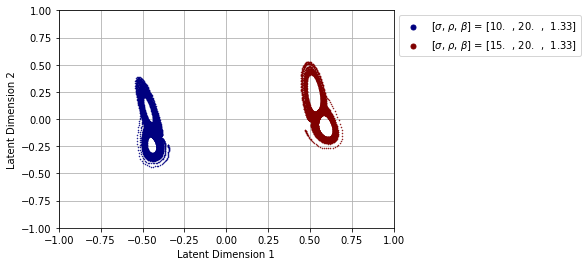

In [17]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_all,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='jet')

In [18]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# LSTM

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.1
    T_sample_input = 10
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving simulation data
    sim_data = {
        'rho_arr':rho_arr,
        'sigma_arr':sigma_arr,
        'beta_arr':beta_arr,
        'x0':x0,
        'y0':y0,
        'z0':z0,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'dir_name_ae':dir_name_ae,
        'normalize_flag':normalize_flag
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'N':N,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [20]:
data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output, num_samples = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True)

In [21]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.0001,
        'eta_high':0.001,
        'eta_low':0.00001
    }
    epochs = 1000
    patience = 50  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [22]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [23]:
idx = np.arange(num_samples)
# np.random.shuffle(idx)
boundary = int(np.round(
    (1-test_split) * num_samples
))

# defining shapes
training_input_shape = [boundary*len(boundary_idx_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [boundary*len(boundary_idx_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [(num_samples-boundary)*len(boundary_idx_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

for i in range(len(boundary_idx_arr)):
    np.random.shuffle(idx)

    training_data_rnn_input[i*boundary:(i+1)*boundary] = data_rnn_input[i*num_samples + idx[0:boundary]]
    training_data_rnn_output[i*boundary:(i+1)*boundary] = data_rnn_output[i*num_samples + idx[0:boundary]]

    testing_data_rnn_input[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_input[i*num_samples + idx[boundary:]]
    testing_data_rnn_output[i*(num_samples-boundary):(i+1)*(num_samples-boundary)] = data_rnn_output[i*num_samples + idx[boundary:]]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [24]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**7]*4
    if return_params_arr != False:
        data_dim = 5
    else:
        data_dim = 2

    rnn_net = RNN_LSTM(
        data_dim=data_dim,
    #     in_steps=int(T_sample_input // dt_rnn),
    #     out_steps=int(T_sample_output // dt_rnn),
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        reg_name='L2',
        rnn_layers_units=rnn_layers_units,
        dense_layer_act_func='linear',
        load_file=None
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    rnn_net = RNN_LSTM(load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = dir_name_rnn+dir_sep+'checkpoints'+dir_sep+'checkpoint'
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_lstm_weights.h5'
    temp = rnn_net(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    rnn_net.load_weights_from_file(wt_file)

In [25]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0])
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [26]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)
    
    # sigmoid annealing lr schedule
    lrschedule_cb = sigmoidWarmupAndDecayLRSchedule(
        eta_begin=learning_rate_dict['eta_begin'],
        eta_high=learning_rate_dict['eta_high'],
        eta_low=learning_rate_dict['eta_low'],
        warmup=20,
        expected_epochs=200,
        g_star=0.999,
        f_star=0.001
    )

    # training the network
    savelosses_cb.update_offset(epochs - num_epochs_left)
    
    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=num_epochs_left,
        batch_size=batch_size,
        validation_split=val_split/train_split,
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])

Epoch 1/675
222/222 [==============================] - 212s 933ms/step - loss: 4.7886e-04 - val_loss: 4.8216e-04
Epoch 2/675
222/222 [==============================] - 207s 933ms/step - loss: 4.7577e-04 - val_loss: 4.8121e-04
Epoch 3/675
222/222 [==============================] - 205s 922ms/step - loss: 4.7568e-04 - val_loss: 4.8116e-04
Epoch 4/675
222/222 [==============================] - 202s 911ms/step - loss: 4.7564e-04 - val_loss: 4.8117e-04
Epoch 5/675
222/222 [==============================] - ETA: 0s - loss: 4.7561e-04 - tot_time: 0h 17m 10.8s

Epoch 5: val_loss improved from inf to 0.00048, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_rnn/rnn_004/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_rnn/rnn_004/checkpoints/LossHistoriesCheckpoint
222/222 [==============================] - 205s 925ms/step - loss: 4.7561e-04 - val_loss: 4.8111e-04
Epoch 6/675
222/222 [=========================

In [27]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

57/57 [==============================] - 8s 134ms/step - loss: 4.8338e-04


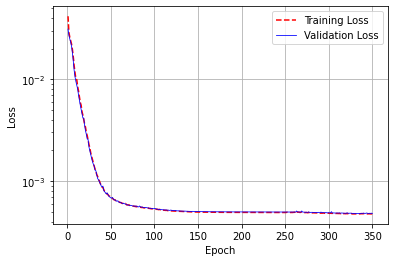

In [28]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 1793


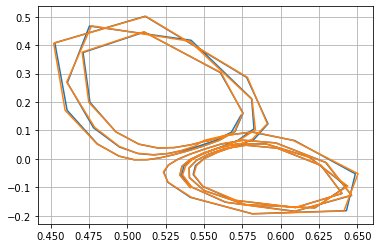

In [29]:
data_idx = np.arange(testing_data_rnn_output.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 10
print('data_idx : {}'.format(data_idx))


plt.plot(testing_data_rnn_output[data_idx, :, 0], testing_data_rnn_output[data_idx, :, 1])
prediction = rnn_net.predict(testing_data_rnn_input[data_idx:data_idx+1, :, :])
plt.plot(prediction[0, :, 0], prediction[0, :, 1])

plt.grid(True)
plt.show()